In [1]:
import os
import json
import uuid
import matplotlib.pyplot as plt
import networkx as nx
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


In [78]:
def run_sparql_query(query, limit=20):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setReturnFormat(JSON)
    sparql.setQuery(query.replace("LIMIT 20", f"LIMIT {limit}"))
    return sparql.query().convert()

In [79]:
def generate_id():
    return str(uuid.uuid4())

In [110]:
def visualize_graph(sample, title="Knowledge Graph"):
    G = nx.DiGraph()

    for node in sample["graph"]["nodes"]:
        G.add_node(node["id"], label=node["label"])

    for edge in sample["graph"]["edges"]:
        G.add_edge(edge["source"], edge["target"], relation=edge["relation"])

    pos = nx.spring_layout(G, seed=42)
    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'relation')

    plt.figure(figsize=(6, 6))
    nx.draw(G, pos, with_labels=True, labels=labels, node_size=800, node_color="lightblue", arrows=True)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [120]:
def generate_one_hop(limit=10):
    
    query = f"""
    SELECT ?countryLabel ?personLabel WHERE {{
      ?country wdt:P463 wd:Q458.   # P463 = member of org; Q458 = European Union
      ?country wdt:P35 ?person.    # P35 = head of state
      ?person wdt:P31 wd:Q5.       # Q5 = human
      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    LIMIT {limit}
    """
    results = run_sparql_query(query, limit)
    dataset = []

    for r in results['results']['bindings']:
        country = r['countryLabel']['value']
        person = r['personLabel']['value']
        cid, pid = generate_id(), generate_id()

        sample = {
            "question": f"Who is the head of state of {country}?",
            "answer": person,
            "entity": country,
            "complexity": "simple",
            "requires_traversal": False,
            "graph": {
                "nodes": [
                    {"id": cid, "label": country},
                    {"id": pid, "label": person}
                ],
                "edges": [
                    {"source": pid, "target": cid, "relation": "head of state"}
                ]
            }
        }
        dataset.append(sample)
        # visualize_graph(sample)
    return dataset

In [121]:
sample_1hop = generate_one_hop(20)

df_1hop = pd.DataFrame([{"question": item["question"],"answer": item["answer"],"entity": item["entity"],"complexity": 
                    item["complexity"],"requires_traversal": item["requires_traversal"]} for item in sample_1hop])

df_1hop

,question,answer,entity,complexity,requires_traversal
0,Who is the head of state of Luxembourg?,"Henri, Grand Duke of Luxembourg",Luxembourg,simple,False
1,Who is the head of state of United Kingdom?,Charles III,United Kingdom,simple,False
2,Who is the head of state of Sweden?,Carl XVI Gustaf of Sweden,Sweden,simple,False
3,Who is the head of state of Ireland?,Michael D. Higgins,Ireland,simple,False
4,Who is the head of state of Croatia?,Zoran Milanović,Croatia,simple,False
5,Who is the head of state of Germany?,Frank-Walter Steinmeier,Germany,simple,False
6,Who is the head of state of Austria?,Alexander Van der Bellen,Austria,simple,False
7,Who is the head of state of Kingdom of the Net...,William Alexander of the Netherlands,Kingdom of the Netherlands,simple,False
8,Who is the head of state of Belgium?,Philippe of Belgium,Belgium,simple,False
9,Who is the head of state of Spain?,Felipe VI of Spain,Spain,simple,False


In [123]:
def generate_two_hop_1(limit=20):
    query = f"""
    SELECT ?countryLabel ?leaderLabel ?birthplaceLabel WHERE {{
      ?country wdt:P463 wd:Q458.                 # EU member
      ?country p:P35 ?statement.                 # Full path to head of state
      ?statement ps:P35 ?leader.
      FILTER NOT EXISTS {{ ?statement pq:P582 ?end. }}  # Only current leaders
      ?leader wdt:P19 ?birthplace.              # Place of birth
      ?leader wdt:P31 wd:Q5.                    # Must be human

      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    LIMIT {limit}
    """
    results = run_sparql_query(query, limit)
    dataset = []

    for r in results["results"]["bindings"]:
        country = r["countryLabel"]["value"]
        leader = r["leaderLabel"]["value"]
        birthplace = r["birthplaceLabel"]["value"]
        cid, lid, bid = generate_id(), generate_id(), generate_id()

        sample = {
            "question": f"Where was the head of state of {country} born?",
            "answer": birthplace,
            "entity": country,
            "complexity": "complex",
            "requires_traversal": True,
            "traversal_hints": f"Find the head of state of {country}, then get their birthplace.",
            "graph": {
                "nodes": [
                    {"id": cid, "label": country},
                    {"id": lid, "label": leader},
                    {"id": bid, "label": birthplace}
                ],
                "edges": [
                    {"source": lid, "target": cid, "relation": "head of state"},
                    {"source": lid, "target": bid, "relation": "place of birth"}
                ]
            }
        }
        dataset.append(sample)

    return dataset

In [124]:
sample_2hop_1 = generate_two_hop_1(limit=20)
df_2hop_1 = pd.DataFrame([{"question": item["question"],"answer": item["answer"],"entity": 
                         item["entity"],"complexity": item["complexity"],
                    "requires_traversal": item["requires_traversal"]} for item in sample_2hop_1])

df_2hop_1

,question,answer,entity,complexity,requires_traversal
0,Where was the head of state of Luxembourg born?,Betzdorf Castle,Luxembourg,complex,True
1,Where was the head of state of Sweden born?,Haga Palace,Sweden,complex,True
2,Where was the head of state of Ireland born?,Limerick,Ireland,complex,True
3,Where was the head of state of Belgium born?,Laeken,Belgium,complex,True
4,Where was the head of state of Spain born?,Madrid,Spain,complex,True
5,Where was the head of state of Finland born?,Helsinki,Finland,complex,True
6,Where was the head of state of Denmark born?,Rigshospitalet,Denmark,complex,True
7,Where was the head of state of Italy born?,Palermo,Italy,complex,True
8,Where was the head of state of Poland born?,Kraków,Poland,complex,True
9,Where was the head of state of Lithuania born?,Klaipėda,Lithuania,complex,True


In [125]:
def generate_two_hop_2(limit=20):
    query = f"""
    SELECT ?countryLabel ?leaderLabel ?universityLabel WHERE {{
      ?country wdt:P463 wd:Q458.                  # EU member
      ?country p:P35 ?statement.                  # Full statement path
      ?statement ps:P35 ?leader.
      FILTER NOT EXISTS {{ ?statement pq:P582 ?end. }}  # Only current leaders
      ?leader wdt:P69 ?university.                # Educated at
      ?leader wdt:P31 wd:Q5.                      # Must be human

      SERVICE wikibase:label {{ bd:serviceParam wikibase:language "en". }}
    }}
    LIMIT {limit}
    """
    results = run_sparql_query(query, limit)
    dataset = []

    for r in results["results"]["bindings"]:
        country = r["countryLabel"]["value"]
        leader = r["leaderLabel"]["value"]
        university = r["universityLabel"]["value"]
        cid, lid, uid = generate_id(), generate_id(), generate_id()

        sample = {
            "question": f"What university did the head of state of {country} attend?",
            "answer": university,
            "entity": country,
            "complexity": "complex",
            "requires_traversal": True,
            "traversal_hints": f"Find the head of state of {country}, then find where they were educated.",
            "graph": {
                "nodes": [
                    {"id": cid, "label": country},
                    {"id": lid, "label": leader},
                    {"id": uid, "label": university}
                ],
                "edges": [
                    {"source": lid, "target": cid, "relation": "head of state"},
                    {"source": lid, "target": uid, "relation": "educated at"}
                ]
            }
        }
        dataset.append(sample)

    return dataset


In [126]:
sample_2hop_2 = generate_two_hop_2(limit=10)

df_2hop_2 = pd.DataFrame([{"question": item["question"],"answer": item["answer"],"entity": item["entity"],"complexity": item["complexity"],
                         "requires_traversal": item["requires_traversal"]
} for item in sample_2hop_2])

df_2hop_2

,question,answer,entity,complexity,requires_traversal
0,What university did the head of state of Luxem...,University of Geneva,Luxembourg,complex,True
1,What university did the head of state of Luxem...,Royal Military Academy Sandhurst,Luxembourg,complex,True
2,What university did the head of state of Luxem...,Lycée classique de Diekirch,Luxembourg,complex,True
3,What university did the head of state of Swede...,Uppsala University,Sweden,complex,True
4,What university did the head of state of Swede...,Sigtunaskolan Humanistiska Läroverket,Sweden,complex,True
5,What university did the head of state of Irela...,University of Manchester,Ireland,complex,True
6,What university did the head of state of Irela...,University of Galway,Ireland,complex,True
7,What university did the head of state of Irela...,Indiana University Bloomington,Ireland,complex,True
8,What university did the head of state of Irela...,Indiana University,Ireland,complex,True
9,What university did the head of state of Irela...,St. Flannan's College,Ireland,complex,True


In [127]:
def generate_three_hop(limit=20):
    
    query = """
    SELECT ?countryLabel ?leaderLabel ?universityLabel ?eduCountryLabel WHERE {
    ?country wdt:P463 wd:Q458.               # EU member
    ?country p:P35 ?statement.               # Full statement path
    ?statement ps:P35 ?leader.               # Leader
    FILTER NOT EXISTS { ?statement pq:P582 ?end. }  # No end date ⇒ current
    
    ?leader wdt:P69 ?university.             # Educated at
    ?university wdt:P17 ?eduCountry.         # University located in country
    ?leader wdt:P31 wd:Q5.                   # Must be human

    SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
    }
    LIMIT 20
    """
    results = run_sparql_query(query, limit)
    dataset = []

    for r in results["results"]["bindings"]:
        country = r["countryLabel"]["value"]
        leader = r["leaderLabel"]["value"]
        university = r["universityLabel"]["value"]
        edu_country = r["eduCountryLabel"]["value"]
        cid, lid, uid, ecid = generate_id(), generate_id(), generate_id(), generate_id()

        sample = {
            "question": f"In which country did the head of state of {country} receive their education?",
            "answer": edu_country,
            "entity": country,
            "complexity": "complex",
            "requires_traversal": True,
            "traversal_hints": f"Find the head of state of {country}, then find where they were educated, then find the country where that institution is located.",
            "graph": {
                "nodes": [
                    {"id": cid, "label": country},
                    {"id": lid, "label": leader},
                    {"id": uid, "label": university},
                    {"id": ecid, "label": edu_country}
                ],
                "edges": [
                    {"source": lid, "target": cid, "relation": "head of state"},
                    {"source": lid, "target": uid, "relation": "educated at"},
                    {"source": uid, "target": ecid, "relation": "located in"}
                ]
            }
        }
        dataset.append(sample)
    
    return dataset


In [128]:
sample_3hop = generate_three_hop(limit=10)

df_3hop = pd.DataFrame([{
    "question": item["question"],
    "answer": item["answer"],
    "entity": item["entity"],
    "complexity": item["complexity"],
    "requires_traversal": item["requires_traversal"]
} for item in sample_3hop])

df_3hop

,question,answer,entity,complexity,requires_traversal
0,In which country did the head of state of Denm...,United States,Denmark,complex,True
1,In which country did the head of state of Belg...,United States,Belgium,complex,True
2,In which country did the head of state of Belg...,United Kingdom,Belgium,complex,True
3,In which country did the head of state of Spai...,United States,Spain,complex,True
4,In which country did the head of state of Finl...,United Kingdom,Finland,complex,True
5,In which country did the head of state of Denm...,France,Denmark,complex,True
6,In which country did the head of state of Swed...,Sweden,Sweden,complex,True
7,In which country did the head of state of Pola...,Poland,Poland,complex,True
8,In which country did the head of state of Ital...,Italy,Italy,complex,True
9,In which country did the head of state of Irel...,United Kingdom,Ireland,complex,True


In [129]:
full_dataset = sample_1hop + sample_2hop_1 + sample_2hop_2 + sample_3hop

In [95]:
output_path = "../data/qa_dataset_wikidata.json"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

with open(output_path, "w", encoding="utf-8") as f:
    json.dump(full_dataset, f, indent=2, ensure_ascii=False)

In [130]:
len(full_dataset)

60

#### Graph visualization of generated questions

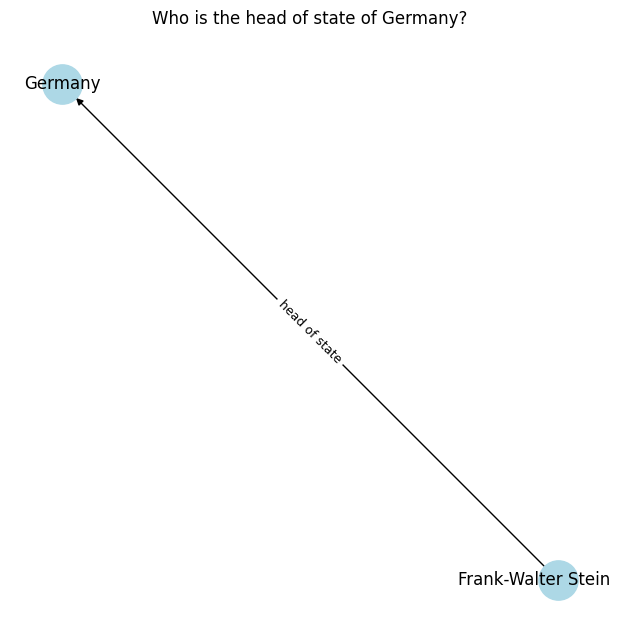

In [119]:
# 1hop example
visualize_graph(full_dataset[5], title=full_dataset[5]["question"])

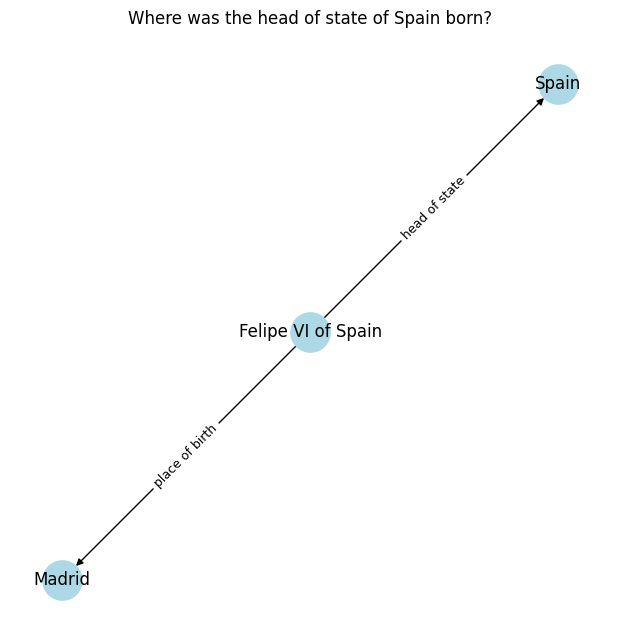

In [ ]:
# 2hop example
visualize_graph(full_dataset[25], title=full_dataset[25]["question"])

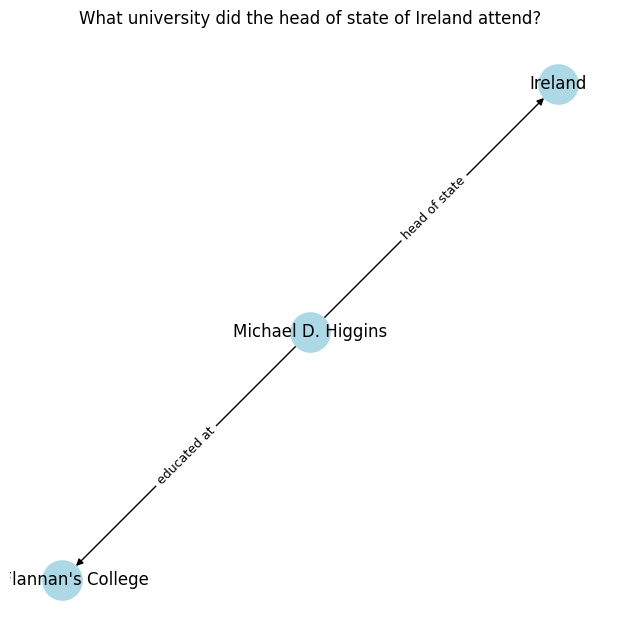

In [118]:
# 2hop example
visualize_graph(full_dataset[49], title=full_dataset[49]["question"])

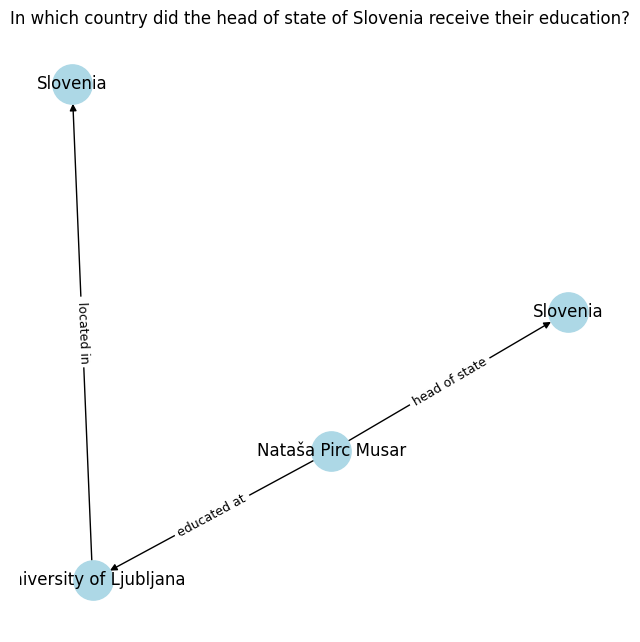

In [ ]:
# 3hop example
visualize_graph(full_dataset[50], title=full_dataset[50]["question"])


In [ ]:
# format the labels so we can get proper context
relation_to_pid = {
    "head of state": "P35",
    "place of birth": "P19",
    "educated at": "P69",
    "located in": "P17"
}

def prepare_dataset_for_context_generation(raw_dataset, relation_map):
    enriched_dataset = []

    for item in raw_dataset:
        graph = item.get("graph", {})
        nodes = graph.get("nodes", [])
        edges = graph.get("edges", [])

        for edge in edges:
            rel = edge.get("relation", "").strip().lower()
            pid = relation_map.get(rel)
            edge["relation_id"] = pid if pid else "UNKNOWN"

        id_to_label = {}
        for node in nodes:
            node_id = node["id"]
            label = node["label"]
            if isinstance(label, dict):
                id_to_label[node_id] = next(iter(label.values()))
            else:
                id_to_label[node_id] = label

        triples = []
        for edge in edges:
            s = edge["source"]
            p = edge.get("relation_id", "UNKNOWN")
            o = edge["target"]
            rel_label = edge.get("relation", "unknown relation")
            obj_label = id_to_label.get(o, o)
            triples.append([s, p, o, rel_label, obj_label])

        item["triples"] = triples
        enriched_dataset.append(item)

    return enriched_dataset


In [7]:
with open("../data/qa_dataset_wikidata.json", "r", encoding="utf-8") as f:
    dataset = json.load(f)

labeled_dataset = prepare_dataset_for_context_generation(dataset, relation_to_pid)

with open("../data/qa_labeled.json", "w", encoding="utf-8") as f:
    json.dump(labeled_dataset, f, indent=2, ensure_ascii=False)